# Árbol de decisión con clasificación
El objetivo es contruir un modelo de clasificación medinate Árboles de Decisión usando datos sintéticos.

author: Virginia Ordoño Bernier

date: January 2024

### 1. Generación de datos

In [125]:
import numpy as np

np.random.seed(41)

# 2 dimensions array. Distribution with Mean 0 and Standard Deviation 1. 
class_0_data = np.random.normal(0, 1, size=(100, 2))
class_0_labels = np.zeros(100) # Labels as 0s

# 2 dimensions array. Distribution with Mean 3 and Standard Deviation 1.
class_1_data = np.random.normal(3, 1, size=(100, 2))
class_1_labels = np.ones(100) # Labels as 1s

### 2. Construcción del dataframe

In [126]:
import pandas as pd

X = np.vstack((class_0_data, class_1_data)) # Join two arrays with stack shape
y = np.concatenate((class_0_labels, class_1_labels)) # Concatenates target columns in one

df_classes = pd.concat([pd.DataFrame(X, columns=['feature_1', 'feature_2']) ,  pd.DataFrame(y, columns=['target'])], axis=1)

# Casting target values as int
df_classes.target = df_classes.target.astype(int)
df_classes.target 

0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: target, Length: 200, dtype: int32

### 3. Gráfico de dispersión

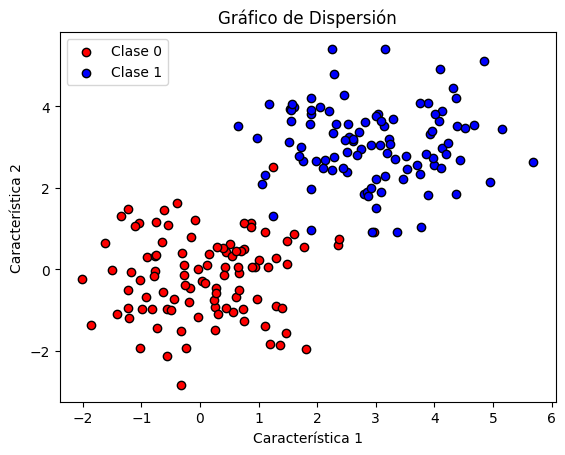

In [127]:
import matplotlib.pyplot as plt

COLORS = ('red', 'blue')

for i, data in enumerate((class_0_data, class_1_data)):
    plt.scatter(data[:, 0], data[:, 1], c=COLORS[i], edgecolor='k', label=f"Clase {i}")

plt.title('Gráfico de Dispersión')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()

plt.show()

### 4. Preparación de los datos para el entrenamiento

In [128]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_classes, test_size=0.33, random_state=42)

# Reset index to maintain an order
train.reset_index(inplace = True)
test.reset_index(inplace = True)

print("Conjunto de entrenamiento:")
print(train.head())

print("\nConjunto de prueba:")
print(test.head())

Conjunto de entrenamiento:
   index  feature_1  feature_2  target
0     42  -1.338782   1.320063       0
1    189   0.972373   3.227486       1
2     90  -1.234605   1.470797       0
3    136   2.247596   2.442699       1
4     51  -0.634127  -0.561483       0

Conjunto de prueba:
   index  feature_1  feature_2  target
0     95  -1.205791  -1.190786       0
1     15   1.015425   0.224081       0
2     30   1.803952  -1.948671       0
3    158   3.917554   3.329283       1
4    128   2.928391   0.908526       1


### 5. Validación cruzada: optimización de parámetros

Mayor precisión: 0.88
Mejor profundidad: 1


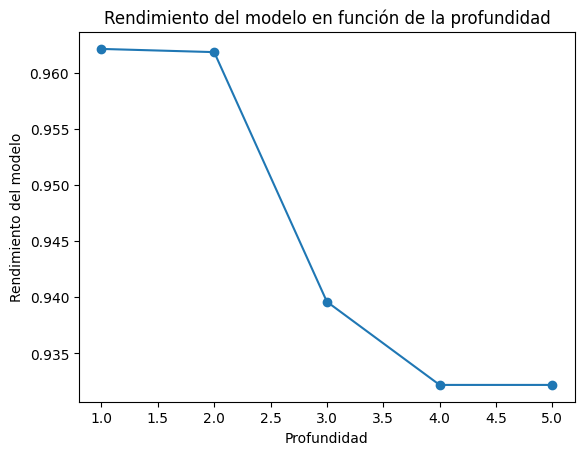

In [129]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

cv = KFold(n_splits=5)
accuracies = []

# Depth range between one and double attributes number 
max_attributes = len(list(df_classes))
depth_range = range(1, max_attributes * 2)

# Storing variables
max_accuracy = 0 
best_depth = 0     

for depth in depth_range:
    fold_accuracy = []
    classifier = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)

    for train_fold, test_fold in cv.split(train):
        f_train = df_classes.loc[train_fold] # Select rows for training group 
        f_test = df_classes.loc[test_fold] # Select rows for test group 

        # Model training
        model = classifier.fit(X=f_train.drop(['target'], axis=1), y=f_train['target'])
        y_pred = model.predict(X=f_test.drop(['target'], axis=1))
        
        # Evaluación del modelo
        avg_accuracy = accuracy_score(f_test['target'], y_pred)
        fold_accuracy.append(avg_accuracy)
        
    # Añadir el promedio de precisión a la lista
    accuracies.append(sum(fold_accuracy) / len(fold_accuracy))

    # Actualizar las variables de la mejor precisión y profundidad
    if avg_accuracy > max_accuracy:
        max_accuracy = avg_accuracy
        best_depth = depth

plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('Profundidad')
plt.ylabel('Rendimiento del modelo')
plt.title('Optimización de parámetros')

print(f"Mayor precisión: {max_accuracy:.2f}")
print(f"Mejor profundidad: {best_depth}")
plt.show()


### 6. Creación del modelo con los mejores hiperparámetros

In [132]:
from sklearn.metrics import classification_report

X_train = train.drop(['target'], axis=1)
y_train = train['target']

X_test = test.drop(['target'], axis=1)
y_test = test['target']

model = DecisionTreeClassifier(max_depth = best_depth)
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

print("\nInforme de Clasificación")
print(classification_report(y_test, y_pred)) 


Informe de Clasificación Índice de Gini:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        31

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66



### 7. Visualizacion del árbol de decisión

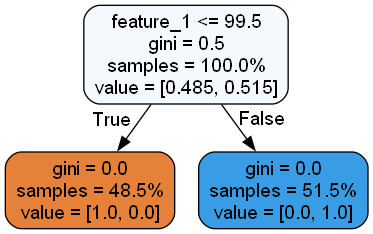

In [135]:
import pydot
from IPython.display import Image
from io import StringIO
from sklearn.tree import export_graphviz

dot_data = StringIO()
column_names = df_classes.columns
export_graphviz(model, out_file = dot_data, proportion = True, feature_names = df_classes.columns, rounded = True, filled = True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

### 8. Visualización de la importancia de las variables
La importancia de las variables se deriva del propio modelo, y se calcula observando cómo cada característica contribuye a reducir la impureza (o aumentar la pureza) de los nodos en el árbol de decisión durante el proceso de entrenamiento.

Informe de Importancia:
     Feature  Importance
1  feature_1         0.0
2  feature_2         0.0


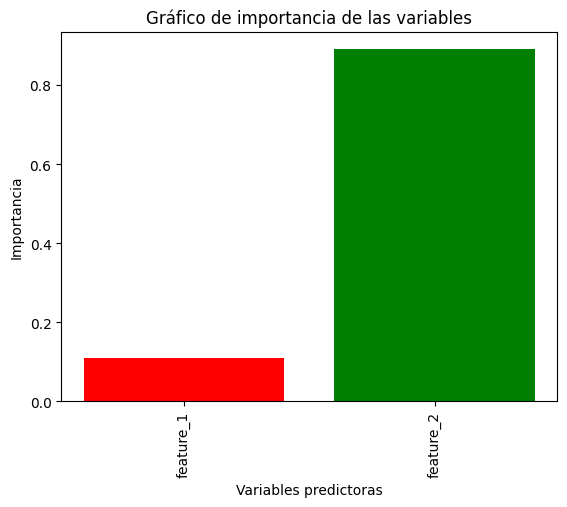

In [140]:
importances = model.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Exclude column 'index' if exists
if 'index' in feature_importance_df['Feature'].values:
    feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'index']

# Order by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Informe de Importancia:")
print(feature_importance_df)

# Gráfico de importancia de las variables
feature_names = df_classes.columns[:-1]
feature_importances = classifier.feature_importances_
colors = ['red', 'green', 'blue', 'orange', 'purple']
plt.bar(feature_names, feature_importances, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Variables predictoras')
plt.ylabel('Importancia')
plt.title('Gráfico de importancia de las variables')
plt.show()